In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt

In [2]:
#Read in tower coords and set up dataframe
tc = pd.read_csv('../Misc_data/tower_coords.csv') #datafrane of tower coordinates
tc.set_index('Tower', inplace = True)

#Convert lat and lon to coordinates in km, origin currently set to PFA coordinates, should change this since PFk is out of range
tc['x'] = (tc.Lon - tc.Lon['PFA'])*111*np.cos(tc.Lat['PFA']*np.pi/180)
tc['y'] = (tc.Lat - tc.Lat['PFA'])*111 


In [ ]:
# #Collect data at 2, 10, and 30m for each tower

                                 
# #Get dates to use as index from PFb data
# filepath_i = tc.org_path['PFb'] #i for index because I am just using this to set the index
# df_i

#Create empty dataframes for 2, 10, and 30 m
Precip = pd.DataFrame()
WS = pd.DataFrame()
WD= pd.DataFrame()


for tower in tc.index:
    #print(tower)
    towdat = tc.loc[tower] #Tower data
    filepath = towdat.org_path #Eventually use gap-filled data for top level
    df = pd.read_csv(filepath)
    df = df.applymap(lambda x: np.nan if x == -9999 else x)
    
    
    if tower == 'PFA': #Come back and get 30m data here later

        #Read in PFA data
        filepath = '../Misc_data/US-PFa_HR_201901010000_202001010000.csv' #This is hourly data -> need halfhourly to match up with other towers
        PFA = pd.read_csv(filepath)

        PFA = PFA.applymap(lambda x: np.nan if x == -9999 else x)
        
        
        #Add datetime index
        dt_ts = pd.to_datetime(PFA['TIMESTAMP_START'], format = '%Y%m%d%H%M') + dt.timedelta(minutes = 30) #half hour time stamp
        PFA.set_index(dt_ts, inplace = True)


        #Linear interpolate PFA data to 15 min and then use just min 15 and 45 timestamps
        PFA_interp = PFA.resample('15T').mean().interpolate()
        PFA_interp = PFA_interp[(PFA_interp.index.minute == 15) | (PFA_interp.index.minute == 45)]


        #Cut to fit dates for the rest of the Cheesehead sites
        startdate = dt.datetime(2019, 6, 1)
        enddate = dt.datetime(2019, 11, 1)
        PFA_interp = PFA_interp[startdate: enddate]

        #Shift timestamps by 15 min to line up with other data 
        Corrected_TS_start = PFA_interp.index - dt.timedelta(minutes = 15)
        PFA_interp.set_index(Corrected_TS_start, inplace = True)

        #Add PFA 30 m data to dfs
        ['PFA'] = PFA_interp.TA_F_1_3_1 
        RH_30['PFA'] = PFA_interp.RH_1_3_1
        WS_top['PFA'] = PFA_interp.WS_1_3_1
        WD['PFA'] = PFA_interp.WD_1_3_1
        Ustar['PFA'] = PFA_interp.USTAR_1_3_1
        PA_top['PFA'] = PFA_interp.PA_1_1_1 #Figure out a way to fill in later, only have pressure at top of tower, maybe use average across other towers

        
    
    else:
        #Add datetime index
        dt_ts = pd.to_datetime(df['TIMESTAMP_START'], format = '%Y%m%d%H%M') 
        df.set_index(dt_ts, inplace = True)
        
        
        #Add wind data to dfs
        WS_top[tower] = df.WS_1_1_1
        WD[tower] = df.WD_1_1_1
        Ustar[tower] = df.USTAR_1_1_1
        PA_top[tower] = df.PA_1_1_1
        
        #Towers with only one level
        if towdat.z2 == towdat.z3 == 0:
            TA_10[tower],  TA_30[tower] = np.nan, np.nan
            TA_2[tower] = df.TA_1_1_1
            
            RH_10[tower],  RH_30[tower] = np.nan, np.nan
            RH_2[tower] = df.RH_1_1_1
            
            
        #Towers with two levels
        elif towdat.z3 == 0:
            TA_30[tower] = np.nan
            TA_2[tower] = df.TA_1_2_1
            TA_10[tower] = df.TA_1_1_1
            
            RH_30[tower] = np.nan
            RH_2[tower] = df.RH_1_2_1
            RH_10[tower] = df.RH_1_1_1
            
        #Towers with three levels    
        else:
            TA_30[tower] = df.TA_1_1_1
            TA_10[tower] = df.TA_1_2_1
            TA_2[tower] = df.TA_1_3_1
            
            RH_30[tower] = df.RH_1_1_1
            RH_10[tower] = df.RH_1_2_1
            RH_2[tower] = df.RH_1_3_1
            
            #For PFl, extrapolate 30m TA from 10 and 25m TA
            if tower == 'PFl':
                TA_30[tower] = df.TA_1_1_1 + (df.TA_1_1_1 - df.TA_1_2_1)/3 #/3 from 5/(25-10)
                RH_30[tower] = df.RH_1_1_1 + (df.RH_1_1_1 - df.RH_1_2_1)/3 #/3 from 5/(25-10)

                
                
#Convert RH to H2O concentration
H2O_2 = H2O_calc(TA_2, RH_2)
H2O_10 = H2O_calc(TA_10, RH_10)
H2O_30 = H2O_calc(TA_30, RH_30)



# #Add in PFA data after converting RH to H2O (because only H2O given in PFA dataset)

# #Import data
# filepath = '../Misc_data/US-PFa_HR_201901010000_202001010000.csv' #This is hourly data -> need halfhourly to match up with other towers
# PFA = pd.read_csv(filepath)

# PFA = PFA.applymap(lambda x: np.nan if x == -9999 else x)



In [3]:
#Read in PFA data
filepath = '../Misc_data/US-PFa_HR_201901010000_202001010000.csv' #This is hourly data -> need halfhourly to match up with other towers
PFA = pd.read_csv(filepath)

PFA = PFA.applymap(lambda x: np.nan if x == -9999 else x)


#Add datetime index
dt_ts = pd.to_datetime(PFA['TIMESTAMP_START'], format = '%Y%m%d%H%M') + dt.timedelta(minutes = 30) #half hour time stamp
PFA.set_index(dt_ts, inplace = True)

In [5]:
PFA.columns

Index(['TIMESTAMP_START', 'TIMESTAMP_END', 'CO2_1_1_1', 'CO2_1_2_1',
       'CO2_1_3_1', 'H2O_1_1_1', 'H2O_1_2_1', 'H2O_1_3_1', 'H2O_F_1_3_1',
       'CH4_1_1_1', 'CH4_1_2_1', 'CH4_1_3_1', 'FC_1_1_1', 'FC_1_2_1',
       'FC_1_3_1', 'FCH4_1_1_1', 'SC_1_1_1', 'SC_1_2_1', 'SC_1_3_1',
       'SCH4_1_1_1', 'H', 'H_1_1_1', 'H_1_2_1', 'H_1_3_1', 'LE', 'LE_1_1_1',
       'LE_1_2_1', 'LE_1_3_1', 'SH_1_1_1', 'SH_1_2_1', 'SH_1_3_1', 'SLE_1_1_1',
       'SLE_1_2_1', 'SLE_1_3_1', 'WD_1_1_1', 'WD_1_2_1', 'WD_1_3_1',
       'WD_F_1_3_1', 'WS_1_1_1', 'WS_1_2_1', 'WS_1_3_1', 'WS_F_1_3_1',
       'USTAR_1_1_1', 'USTAR_1_2_1', 'USTAR_1_3_1', 'USTAR_F_1_3_1',
       'PA_1_1_1', 'TA_1_1_1', 'TA_1_2_1', 'TA_1_3_1', 'TA_F_1_3_1',
       'VPD_F_1_3_1', 'SWC_1_1_1', 'PPFD_IN_1_1_1', 'P', 'NEE', 'NEE_F',
       'NEE_1_1_1', 'NEE_1_2_1', 'NEE_1_3_1', 'RECO_F', 'GPP_F', 'RH_1_3_1'],
      dtype='object')

In [8]:
startdate = dt.datetime(2019, 6, 1)
enddate = dt.datetime(2019, 11, 1)
PFA_CH = PFA[startdate:enddate]

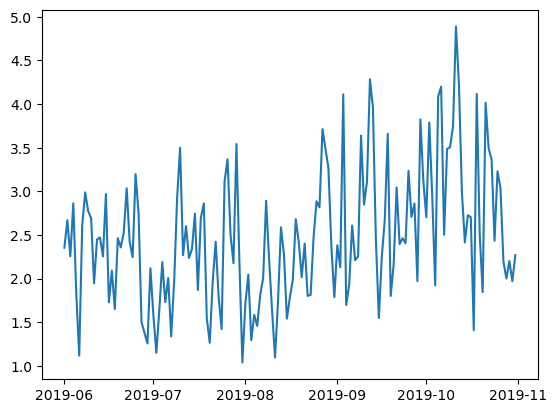

In [15]:
PFA_day = PFA_CH.groupby(PFA_CH.index.date).mean()
plt.plot(PFA_day.WS_1_3_1)

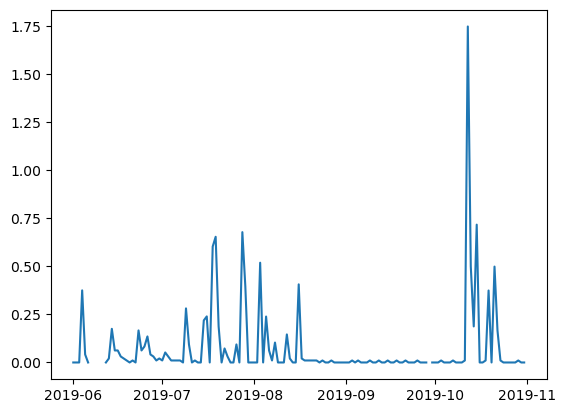

In [16]:
PFA_day_t = PFA_CH.groupby(PFA_CH.index.date).sum()
plt.plot(PFA_day.P)